In [118]:
import numpy as np
import pandas as pd

df = pd.read_csv('cddidi.csv')
weather = pd.read_csv('weathercd.csv')

In [119]:
df.head()

,Unnamed: 0,ID,pickup_datetime,dropoff_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,value
0,0,eb9dd4095d9850e6287cefd813775a6c,1477964797,1477966507,104.094640,30.703971,104.089270,30.650850,3.54
1,1,387a742fa5a3fbe4a1f215ac58ea33a8,1477985585,1477987675,104.076509,30.767430,104.063700,30.589510,11.70
2,2,9cf55f8e6e02a1e0f792df06e5d85011,1478004952,1478006217,104.019699,30.689007,104.105324,30.663950,5.01
3,3,5feeae0307e15203484b9ffceef89855,1477989840,1477991065,104.036090,30.622690,104.043860,30.682320,4.22
4,4,ad4b52cb15b90c44c8f20a8b1e57a622,1477958005,1477958577,104.115997,30.652313,104.104421,30.695113,2.27


In [120]:
df.drop(['value','ID','Unnamed: 0'],axis=1,inplace=True)

In [121]:
df['trip_duration'] = df['dropoff_datetime'] -df['pickup_datetime']

In [122]:
import time
df['pickup_datetime']=pd.to_datetime(df['pickup_datetime'].values,unit='s',utc=True).tz_convert('Asia/Chongqing')
df['mday'] = df.pickup_datetime.dt.dayofyear-305
df['hour'] = df.pickup_datetime.dt.hour
df['minute'] = df.pickup_datetime.dt.minute
df['second'] = df.pickup_datetime.dt.second
df['minute_oftheday'] = df['hour'] * 60 + df['minute']
df.head()

,pickup_datetime,dropoff_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration,mday,hour,minute,second,minute_oftheday
0,2016-11-01 09:46:37+08:00,1477966507,104.094640,30.703971,104.089270,30.650850,1710,1,9,46,37,586
1,2016-11-01 15:33:05+08:00,1477987675,104.076509,30.767430,104.063700,30.589510,2090,1,15,33,5,933
2,2016-11-01 20:55:52+08:00,1478006217,104.019699,30.689007,104.105324,30.663950,1265,1,20,55,52,1255
3,2016-11-01 16:44:00+08:00,1477991065,104.036090,30.622690,104.043860,30.682320,1225,1,16,44,0,1004
4,2016-11-01 07:53:25+08:00,1477958577,104.115997,30.652313,104.104421,30.695113,572,1,7,53,25,473


In [123]:
weather['date'] = pd.to_datetime(weather.date, format='%d-%m-%Y')
weather['mday'] = weather.date.dt.dayofyear-305
df = pd.merge(df, weather, on='mday')

In [124]:
df.drop_duplicates(subset=None,keep='first',inplace=True)

In [125]:
df.drop([ 'pickup_datetime','dropoff_datetime','date','minute'], axis=1, inplace=True)

In [126]:
df.head()

,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration,mday,hour,second,minute_oftheday,maximum temperature,minimum temperature,average temperature,air quality index
0,104.094640,30.703971,104.089270,30.650850,1710,1,9,37,586,17,11,14.0,92
1,104.076509,30.767430,104.063700,30.589510,2090,1,15,5,933,17,11,14.0,92
2,104.019699,30.689007,104.105324,30.663950,1265,1,20,52,1255,17,11,14.0,92
3,104.036090,30.622690,104.043860,30.682320,1225,1,16,0,1004,17,11,14.0,92
4,104.115997,30.652313,104.104421,30.695113,572,1,7,25,473,17,11,14.0,92


In [127]:
df = df[(df.trip_duration > 0)]
m = np.mean(df.trip_duration)
s = np.std(df.trip_duration)
df = df[(df.trip_duration < m + 2 * s)]
df = df[(df.trip_duration > m - 2 * s)]


# 计算球面距离

def ft_haversine_distance(lat1, lng1, lat2, lng2):
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    AVG_EARTH_RADIUS = 6371  # km
    lat = lat2 - lat1
    lng = lng2 - lng1
    d = np.sin(lat * 0.5) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(lng * 0.5) ** 2
    h = 2 * AVG_EARTH_RADIUS * np.arcsin(np.sqrt(d))
    return h


# Add distance feature
df['distance'] = ft_haversine_distance(df['pickup_latitude'].values,
                                       df['pickup_longitude'].values,
                                       df['dropoff_latitude'].values,
                                       df['dropoff_longitude'].values)

# 根据起始点角度计算方向
def ft_degree(lat1, lng1, lat2, lng2):
    AVG_EARTH_RADIUS = 6371  # km
    lng_delta_rad = np.radians(lng2 - lng1)
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    y = np.sin(lng_delta_rad) * np.cos(lat2)
    x = np.cos(lat1) * np.sin(lat2) - np.sin(lat1) * np.cos(lat2) * np.cos(lng_delta_rad)
    return np.degrees(np.arctan2(y, x))


# Add direction feature
df['direction'] = ft_degree(df['pickup_latitude'].values,
                        df['pickup_longitude'].values,
                        df['dropoff_latitude'].values,
                        df['dropoff_longitude'].values)



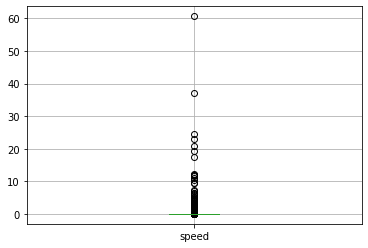

In [128]:
# Create speed feature
df['speed'] = df.distance / df.trip_duration
#Visualize speed feature
df.boxplot(column='speed', return_type='axes');


In [129]:
# Remove speed outliers
df = df[(df.speed < 10)]
df.drop(['speed'], axis=1, inplace=True)

In [130]:
df.head()

,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration,mday,hour,second,minute_oftheday,maximum temperature,minimum temperature,average temperature,air quality index,distance,direction
0,104.094640,30.703971,104.089270,30.650850,1710,1,9,37,586,17,11,14.0,92,5.929068,-175.029671
1,104.076509,30.767430,104.063700,30.589510,2090,1,15,5,933,17,11,14.0,92,19.821688,-176.453661
2,104.019699,30.689007,104.105324,30.663950,1265,1,20,52,1255,17,11,14.0,92,8.649731,108.769054
3,104.036090,30.622690,104.043860,30.682320,1225,1,16,0,1004,17,11,14.0,92,6.672082,6.393998
4,104.115997,30.652313,104.104421,30.695113,572,1,7,25,473,17,11,14.0,92,4.886216,-13.092588


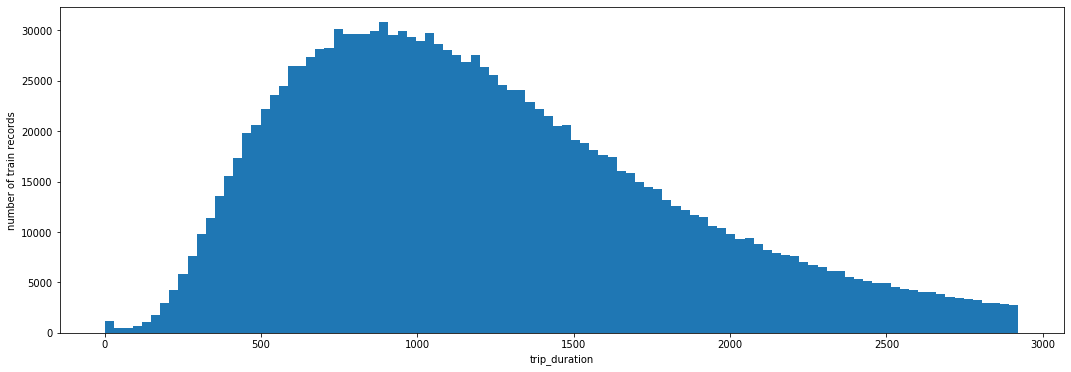

In [131]:
#Visualize the distribution of trip_duration values
import matplotlib.pyplot as plt
plt.subplots(figsize=(18,6))
plt.hist(df['trip_duration'].values, bins=100)
plt.xlabel('trip_duration')
plt.ylabel('number of train records')
plt.show()

In [132]:
df.describe()

,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration,mday,hour,second,minute_oftheday,maximum temperature,minimum temperature,average temperature,air quality index,distance,direction
count,1.467309e+06,1.467309e+06,1.467309e+06,1.467309e+06,1.467309e+06,1.467309e+06,1.467309e+06,1.467309e+06,1.467309e+06,1.467309e+06,1.467309e+06,1.467309e+06,1.467309e+06,1.467309e+06,1.467309e+06
mean,1.040726e+02,3.067298e+01,1.040722e+02,3.067223e+01,1.215020e+03,5.551725e+00,1.398489e+01,2.951752e+01,8.684282e+02,1.687785e+01,9.497620e+00,1.318773e+01,9.638510e+01,6.029999e+00,5.736579e-01
std,3.903253e-02,3.630952e-02,1.968965e-01,6.801692e-02,5.971606e+02,3.190315e+00,5.384089e+00,1.730378e+01,3.230541e+02,2.736113e+00,1.738949e+00,2.152395e+00,4.409895e+01,2.135560e+01,1.048577e+02
min,1.036137e+02,3.028324e+01,0.000000e+00,0.000000e+00,2.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.300000e+01,8.000000e+00,1.050000e+01,4.000000e+01,0.000000e+00,-1.799988e+02
25%,1.040503e+02,3.065472e+01,1.040505e+02,3.065407e+01,7.560000e+02,3.000000e+00,1.000000e+01,1.500000e+01,6.350000e+02,1.400000e+01,8.000000e+00,1.100000e+01,6.300000e+01,3.078752e+00,-8.939413e+01
50%,1.040732e+02,3.067033e+01,1.040734e+02,3.067002e+01,1.120000e+03,7.000000e+00,1.400000e+01,3.000000e+01,8.790000e+02,1.600000e+01,8.000000e+00,1.200000e+01,7.300000e+01,5.047480e+00,6.990852e-01
75%,1.040968e+02,3.069106e+01,1.040967e+02,3.069169e+01,1.585000e+03,9.000000e+00,1.800000e+01,4.400000e+01,1.127000e+03,2.000000e+01,1.200000e+01,1.600000e+01,1.540000e+02,7.864206e+00,9.242376e+01
max,1.044144e+02,3.099836e+01,1.203615e+02,3.137100e+01,2.922000e+03,1.000000e+01,2.300000e+01,5.900000e+01,1.439000e+03,2.100000e+01,1.200000e+01,1.650000e+01,1.570000e+02,1.135074e+04,1.800000e+02


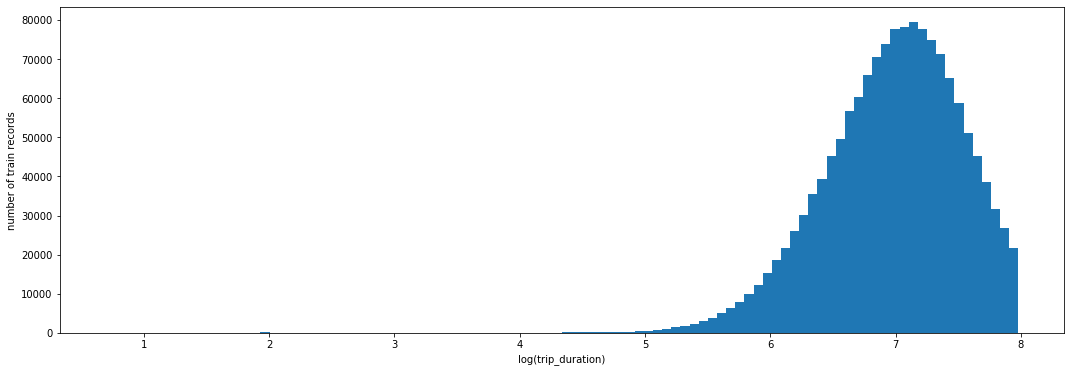

In [133]:
plt.subplots(figsize=(18,6))
df['trip_duration'] = np.log(df['trip_duration'].values)
plt.hist(df['trip_duration'].values, bins=100)
plt.xlabel('log(trip_duration)')
plt.ylabel('number of train records')
plt.show()

In [134]:
df.to_csv("cdlightgbm.csv", index=False)

In [89]:
# Split the labeled data frame into two sets: features and target
y = df["trip_duration"]
df.drop(["trip_duration"], axis=1, inplace=True)
X = df

X.shape, y.shape

((1467309, 14), (1467309,))

In [90]:
# Split the labeled data frame into two sets to train then test the models，测试集比例0.2
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=42)  # random_state设置一样，那么其结果也是一样的
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((1173847, 14), (1173847,), (293462, 14), (293462,))

In [ ]:
test_columns = X.columns
predictions = lgbm.predict(test[test_columns])
submission = pd.DataFrame({'id': test.id,
                           'month':test.month,'week':test.week,'weekday':test.weekday,'minute_oftheday':test.minute_oftheday,
                           'worker_longitude':test.pickup_longitude,'worker_latitude':test.pickup_latitude,
                           'task_longitude':test.dropoff_longitude,'task_latitude':test.dropoff_latitude,
                            'reputation':np.random.rand(len(test)), 'budget':75, 
                           'trip_duration': np.exp(predictions)})

submission.head()
submission.to_csv("data_raw.csv", index=False)
